In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/")
import importlib
import structures
importlib.reload(structures)
from structures import *
#import losses
#importlib.reload(losses)
#from losses import *
#import trainer
#importlib.reload(trainer)
#from trainer import *
#dtype = torch.float32
#dtype = torch.double
dtype = torch.float32
torch.set_default_dtype(dtype)
torch.autograd.set_detect_anomaly(True)
# Set the device to CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

import deepspeed
import random
sys.path.append("/mnt/home/yjo10/ceph/myutils")
import plt_utils as pu

torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()
# Cosine‑annealing with warmup
from timm.scheduler import create_scheduler
from types import SimpleNamespace
from tqdm import tqdm


Using device: cuda
[2025-05-08 23:36:06,930] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/mnt/sw/nix/store/r3bwp9b2501bv77y6g1nwkb483p0y9z2-cuda-12.3.2/lib64/libcufile.so: undefined reference to `dlvsym'
/mnt/sw/nix/store/r3bwp9b2501bv77y6g1nwkb483p0y9z2-cuda-12.3.2/lib64/libcufile.so: undefined reference to `dlopen'
/mnt/sw/nix/store/r3bwp9b2501bv77y6g1nwkb483p0y9z2-cuda-12.3.2/lib64/libcufile.so: undefined reference to `dlclose'
/mnt/sw/nix/store/r3bwp9b2501bv77y6g1nwkb483p0y9z2-cuda-12.3.2/lib64/libcufile.so: undefined reference to `dlerror'
/mnt/sw/nix/store/r3bwp9b2501bv77y6g1nwkb483p0y9z2-cuda-12.3.2/lib64/libcufile.so: undefined reference to `dlsym'
/mnt/sw/nix/store/r3bwp9b2501bv77y6g1nwkb483p0y9z2-cuda-12.3.2/lib64/libcufile.so: undefined reference to `shm_open'
/mnt/sw/nix/store/r3bwp9b2501bv77y6g1nwkb483p0y9z2-cuda-12.3.2/lib64/libcufile.so: undefined reference to `shm_unlink'
collect2: error: ld returned 1 exit status


## 25 box SB28

### data load

In [2]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
import timm
# Garbage collect
gc.collect()

#batch_size=64
batch_size=64
data, labels,minmax = loadCAMELS(field="Mtot",box="SB28",normalization=True, linear=True, buffer=0.3)
#data, labels, minmax = loadCAMELS(field="Mtot",box="SB28",normalization=True, linear=False, buffer=0.3)
#data, labels, minmax = loadCAMELS(field="Mtot",box="LH",normalization=True, linear=True, buffer=0.3)
labels = labels[:,0:2]
## for CoaT test
#data = data[:,:224,:224]
output_dim = labels.shape[1]

# 3. Load data
data = torch.tensor(data,dtype=dtype)
labels = torch.tensor(labels,dtype=dtype)
train_set, val_set = split_expanded_dataset(data, labels, chunk_size=15, val_ratio=0.2)

In [3]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=4)#, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=4)#, pin_memory=True)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToPILImage

input_dim = 224
angles = [0, 90, 180, 270]
fixed_rotations = [
    transforms.RandomRotation((angle, angle)) for angle in angles
]

# 1. Your grayscale augmentation pipeline
train_tfms = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomCrop(input_dim),
    #transforms.RandomCrop(256),
    #transforms.RandomResizedCrop(256),# scale=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(p=0.2),
    #transforms.RandomChoice(fixed_rotations),

    #transforms.RandomRotation(degrees=(0, 360)),
    #transforms.ColorJitter(brightness=0.4, contrast=0.4),
    #ToPILImage(),                 # convert raw tensor → PIL
    transforms.ToTensor(),        # PIL → normalized tensor
    #transforms.RandomErasing(p=0.25, scale=(0.02, 0.1)),
    #RotateBySet([0, 90, 180, 270]),  # whatever angles you like
    #transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

# 2. A simpler “val” pipeline (no random transforms)
val_tfms = transforms.Compose([
    transforms.ToPILImage(), 
    #transforms.Resize(256),
    #transforms.CenterCrop(256),
    transforms.CenterCrop(input_dim),
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

# 3. Wrap your existing train_set / val_set
train_aug = AugmentedDataset(train_set, train_tfms)
val_aug   = AugmentedDataset(val_set,   val_tfms)

# 4. Create loaders as before
train_loader = DataLoader(train_aug, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_aug,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# 5. Quick sanity check on one batch
imgs, labs = next(iter(train_loader))
print(imgs.shape, labs.shape)  # e.g. torch.Size([batch,1,224,224]), torch.Size([batch])
#imgs, labs = next(iter(val_loader))
#print(imgs.shape, labs.shape)  # e.g. torch.Size([batch,1,224,224]), torch.Size([batch])

torch.Size([64, 1, 224, 224]) torch.Size([64, 2])


In [5]:
imgs, labs = next(iter(train_loader))

In [6]:
imgs.shape, labs.shape

(torch.Size([64, 1, 224, 224]), torch.Size([64, 2]))

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


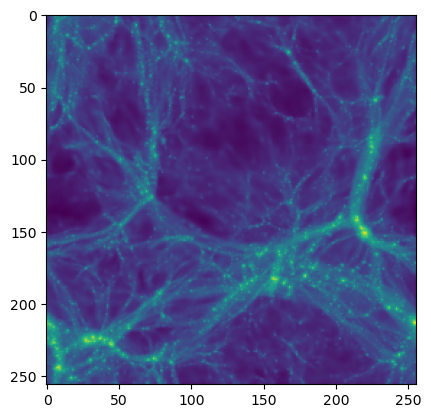

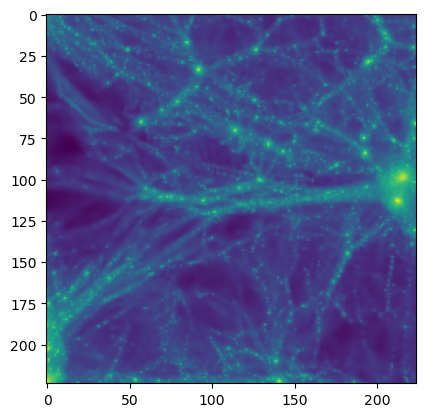

In [7]:
plt.imshow(data[0,:,:])
plt.show()
plt.imshow(imgs[3,0,:,:])
plt.show()

### training

In [8]:
import structures
importlib.reload(structures)
from structures import *
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts
import copy



epochs = 200
lr = 1e-3
# Instantiate the model
try: 
    del model
    del model_engine
    print("model deleted")
except:
    pass

ds_config = {
    "train_batch_size": batch_size,
    #"gradient_accumulation_steps": 1,
    #"optimizer": {
    #    "type": "AdamW",
    #    "params": {"lr": lr, "betas": [0.9, 0.999], "eps": 1e-8, "weight_decay":1e-5}
    #},
    "fp32": {
        "enabled": True  # Enables mixed precision training
    },
    "zero_optimization": {
        "stage": 1  # Enable ZeRO Stage 1 for memory optimization
    }
}

"""
model = CustomCNN(
                input_dim = 256,
                input_channels=1,
                conv_layers=[(2,3), (4,3), (8,3), (16, 3), (32, 3), (64, 3), (128, 3)],  # list of (out_channels, kernel_size)
                hidden_dims=[128],
                output_dim=output_dim,
                activation=nn.ReLU).to(device)
model = CustomCNN(
                input_dim = 256,
                input_channels=1,
                #conv_layers=[(2,4),(2,2), (8,3), (32, 3), (32, 3),(64, 3),(128,3),(256,3),(512,3),(1024,3),(2048,3)],  # list of (out_channels, kernel_size)
                #conv_layers=[(8,3),(8,3),(16, 3),(32, 3)], #,(128,3)], #,(256,3)],  # list of (out_channels, kernel_size)
                conv_layers=[(2,4),(4,4),(8,4),(16,4),(32,4)],#,(32,3)], #,(128,3)], #,(256,3)],  # list of (out_channels, kernel_size)
                hidden_dims=[128,32],
                output_dim=output_dim,
                activation=nn.LeakyReLU,
                output_positive=True,
                ).to(device)
                """

#model = FlexibleCNN(H=16, input_channels=1, input_dim=input_dim, output_dim=output_dim, output_positive=True)
model = ConventionalCNN(input_shape=(input_dim,input_dim), output_shape=output_dim, output_positive=True, H=8)
#model = CoAtNetRegression(model_name='coat_lite_small', output_dim=output_dim, pretrained=False)


model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
total_steps = epochs * len(train_loader)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)
"""
scheduler = OneCycleLR(
    optimizer=optimizer,
    max_lr=1e-3,
    total_steps=total_steps,
    pct_start=0.1,          # 10% warm‑up
    anneal_strategy='cos',  # cosine decay
    div_factor=10.0,        # start at max_lr/div_factor
    final_div_factor=1e4    # end at max_lr/final_div_factor
)
"""
scheduler = CosineAnnealingWarmRestarts(
    optimizer=optimizer,
    T_0=5,     # first cycle length (in epochs)
    T_mult=2,  # cycle length multiplier
    eta_min=1e-7
)
"""
model_engine, optimizer, _, _ = deepspeed.initialize(
    model=model,
    model_parameters=model.parameters(),
    config=ds_config
)
"""

model_engine, optimizer, _, _ = deepspeed.initialize(
    model=model,
    model_parameters=model.parameters(),
    optimizer=optimizer,
    config_params=ds_config
)

class LogMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super(LogMSELoss, self).__init__()
        self.eps = eps  # to prevent log(0)
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        mean = torch.mean((pred-target)**2,dim=0)
        lmse = torch.sum(torch.log(mean))
        return lmse
        """
        pred_log = torch.log(pred)
        target_log = torch.log(target)
        return torch.mean((pred_log - target_log) ** 2)
        """

criterion = nn.MSELoss()
#criterion = LogMSELoss()
best_val_loss = float('inf')

for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    model_engine.train()
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
    #for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model_engine(inputs)
        loss = criterion(outputs, targets)
        model_engine.backward(loss)
        model_engine.step()
        running_loss += loss.item() * inputs.size(0)


    val_loss = 0.0
    model_engine.eval()
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_engine(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss = val_loss / len(val_loader.dataset)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    #scheduler.step(val_loss)
    scheduler.step()

    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")
        pass

    epoch_train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {epoch_train_loss:.4f}/{val_loss:.4f}")


[2025-05-08 23:36:23,058] [INFO] [logging.py:128:log_dist] [Rank -1] DeepSpeed info: version=0.16.4, git-hash=unknown, git-branch=unknown
[2025-05-08 23:36:23,059] [INFO] [comm.py:658:init_distributed] cdb=None
[2025-05-08 23:36:23,060] [INFO] [comm.py:673:init_distributed] Not using the DeepSpeed or dist launchers, attempting to detect MPI environment...


[2025-05-08 23:36:23,900] [INFO] [comm.py:728:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=10.250.149.89, master_port=29500
[2025-05-08 23:36:23,901] [INFO] [comm.py:689:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
[2025-05-08 23:36:23,904] [INFO] [config.py:734:__init__] Config mesh_device None world_size = 1


--------------------------------------------------------------------------
Ignoring value for oob_tcp_if_exclude on workergpu089 (10.250.112.0/20: Did not find interface matching this subnet).
(You can safely ignore this message.)
--------------------------------------------------------------------------


[2025-05-08 23:36:29,180] [INFO] [logging.py:128:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
[2025-05-08 23:36:29,182] [INFO] [logging.py:128:log_dist] [Rank 0] Using client Optimizer as basic optimizer
[2025-05-08 23:36:29,183] [INFO] [logging.py:128:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2025-05-08 23:36:29,185] [INFO] [logging.py:128:log_dist] [Rank 0] DeepSpeed Basic Optimizer = AdamW
[2025-05-08 23:36:29,185] [INFO] [utils.py:59:is_zero_supported_optimizer] Checking ZeRO support for optimizer=AdamW type=<class 'torch.optim.adamw.AdamW'>
[2025-05-08 23:36:29,186] [INFO] [logging.py:128:log_dist] [Rank 0] Creating torch.float32 ZeRO stage 1 optimizer
[2025-05-08 23:36:29,186] [INFO] [stage_1_and_2.py:149:__init__] Reduce bucket size 500000000
[2025-05-08 23:36:29,187] [INFO] [stage_1_and_2.py:150:__init__] Allgather bucket size 500000000
[2025-05-08 23:36:29,187] [INFO] [stage_1_and_2.py:151:__init__] CPU Offload: False
[2

Epoch 1/200:   0%|          | 0/193 [00:00<?, ?it/s]


RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (4 x 4). Kernel size can't be greater than actual input size

#### with cropped to 224 without random rotation without erasing

Validation MSE (average over 2 targets): 0.002745
Validation MSE (average over 2 targets): 0.002208


(0.0022079377, array([0.0002372 , 0.00417867], dtype=float32))

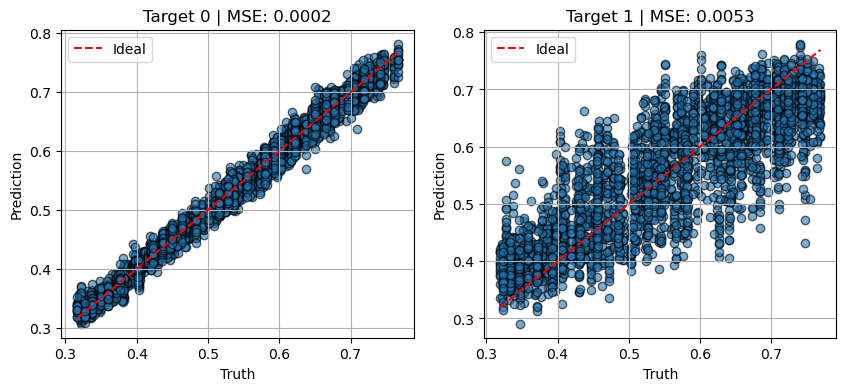

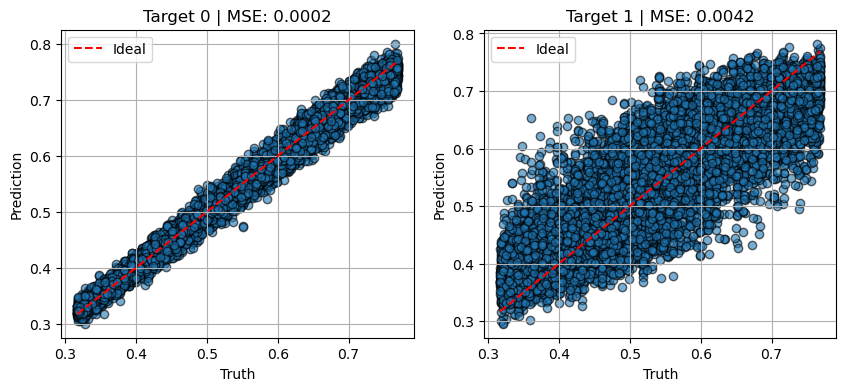

In [52]:
import validator 
importlib.reload(validator)
from validator import *

if False:
    model = CustomCNN(
                input_dim = 256,
                input_channels=1,
                #conv_layers=[(4,3), (8,3), (16, 3), (32, 3)],  # list of (out_channels, kernel_size)
                conv_layers=[(2,3),(4,3), (8,3), (16, 3), (32, 3),(64,3)],  # list of (out_channels, kernel_size)
                hidden_dims=[128, 32],
                output_dim=output_dim,
                output_positive=True,
                activation=nn.LeakyReLU).to(device)
    model.load_state_dict(torch.load("../data/models/SB28_epoch160.pt"))


validate_multi_output_regression(best_model, val_loader, device=device, max_plots=6)
validate_multi_output_regression(best_model, train_loader, device=device, max_plots=6)

#### with cropped to 224 with random rotation without erasing

Validation MSE (average over 2 targets): 0.002995


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Validation MSE (average over 2 targets): 0.002817


(0.0028169907, array([0.00037632, 0.00525766], dtype=float32))

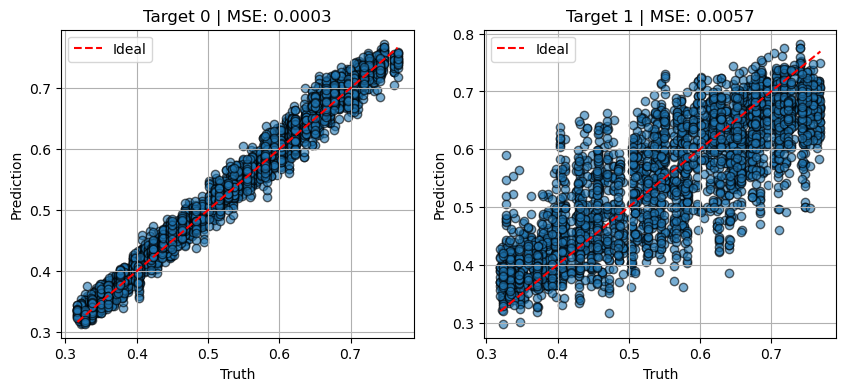

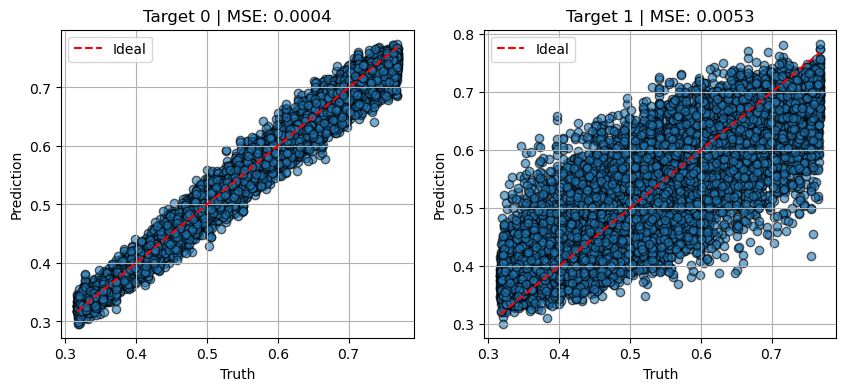

In [49]:
import validator 
importlib.reload(validator)
from validator import *

if False:
    model = CustomCNN(
                input_dim = 256,
                input_channels=1,
                #conv_layers=[(4,3), (8,3), (16, 3), (32, 3)],  # list of (out_channels, kernel_size)
                conv_layers=[(2,3),(4,3), (8,3), (16, 3), (32, 3),(64,3)],  # list of (out_channels, kernel_size)
                hidden_dims=[128, 32],
                output_dim=output_dim,
                output_positive=True,
                activation=nn.LeakyReLU).to(device)
    model.load_state_dict(torch.load("../data/models/SB28_epoch160.pt"))


validate_multi_output_regression(best_model, val_loader, device=device, max_plots=6)
validate_multi_output_regression(best_model, train_loader, device=device, max_plots=6)

#### with random rotation

Validation MSE (average over 2 targets): 0.004038


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Validation MSE (average over 2 targets): 0.004338


(0.0043382808, array([0.00093786, 0.00773871], dtype=float32))

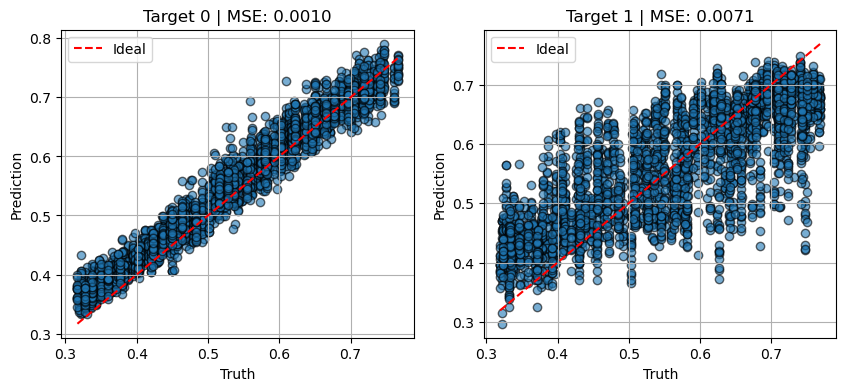

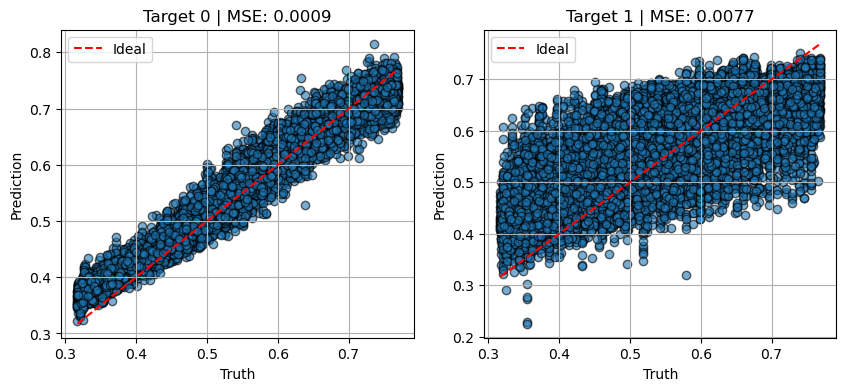

In [ ]:
import validator 
importlib.reload(validator)
from validator import *

if False:
    model = CustomCNN(
                input_dim = 256,
                input_channels=1,
                #conv_layers=[(4,3), (8,3), (16, 3), (32, 3)],  # list of (out_channels, kernel_size)
                conv_layers=[(2,3),(4,3), (8,3), (16, 3), (32, 3),(64,3)],  # list of (out_channels, kernel_size)
                hidden_dims=[128, 32],
                output_dim=output_dim,
                output_positive=True,
                activation=nn.LeakyReLU).to(device)
    model.load_state_dict(torch.load("../data/models/SB28_epoch160.pt"))


validate_multi_output_regression(best_model, val_loader, device=device, max_plots=6)
validate_multi_output_regression(best_model, train_loader, device=device, max_plots=6)

#### without erasing

Validation MSE (average over 2 targets): 0.002424
Validation MSE (average over 2 targets): 0.001477


(0.0014772076, array([0.00019729, 0.00275712], dtype=float32))

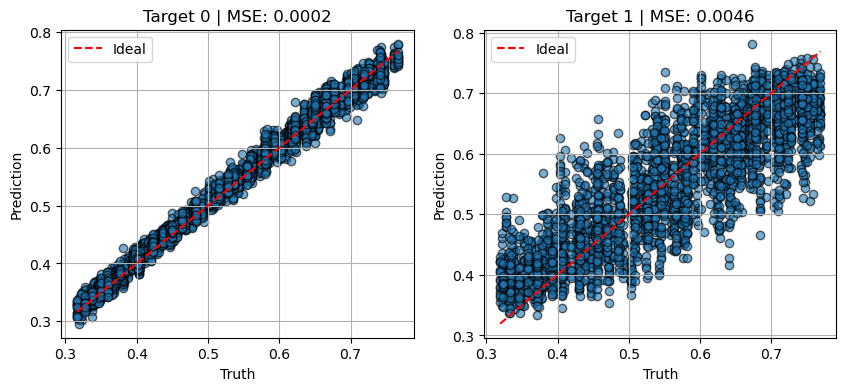

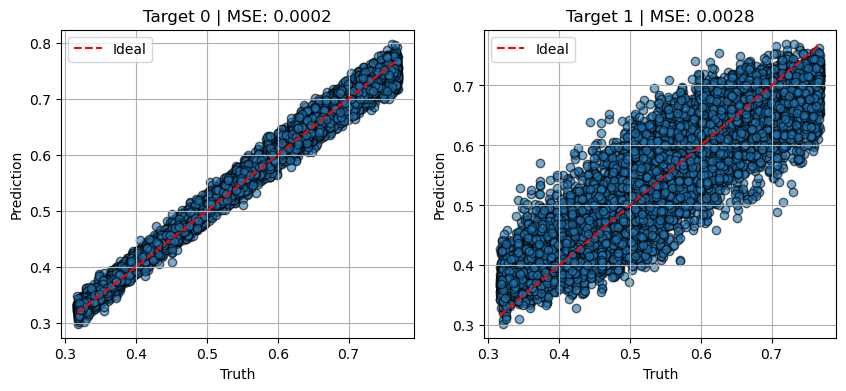

In [53]:
import validator 
importlib.reload(validator)
from validator import *

if False:
    model = CustomCNN(
                input_dim = 256,
                input_channels=1,
                #conv_layers=[(4,3), (8,3), (16, 3), (32, 3)],  # list of (out_channels, kernel_size)
                conv_layers=[(2,3),(4,3), (8,3), (16, 3), (32, 3),(64,3)],  # list of (out_channels, kernel_size)
                hidden_dims=[128, 32],
                output_dim=output_dim,
                output_positive=True,
                activation=nn.LeakyReLU).to(device)
    model.load_state_dict(torch.load("../data/models/SB28_epoch160.pt"))


validate_multi_output_regression(best_model, val_loader, device=device, max_plots=6)
validate_multi_output_regression(best_model, train_loader, device=device, max_plots=6)

#### with erasing

Validation MSE (average over 2 targets): 0.002464
Validation MSE (average over 2 targets): 0.001605


(0.0016045115, array([0.00021497, 0.00299405], dtype=float32))

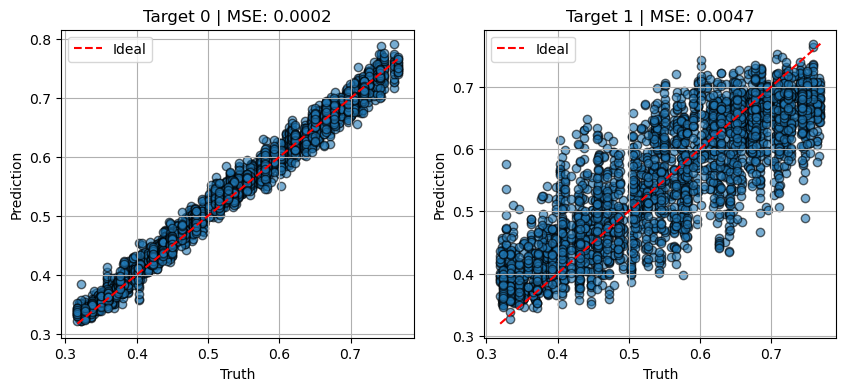

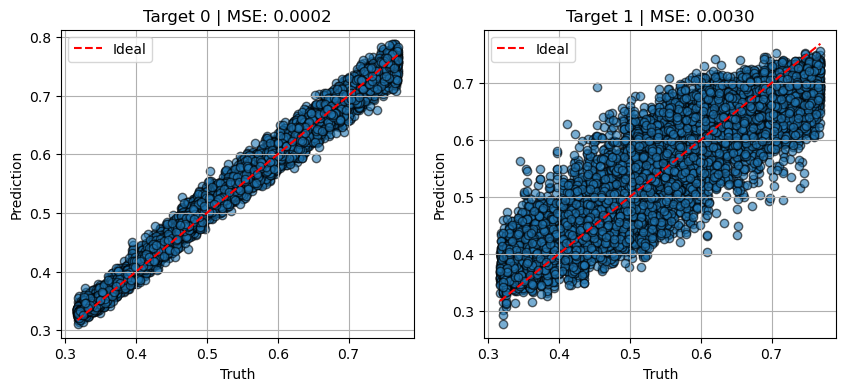

In [ ]:
import validator 
importlib.reload(validator)
from validator import *

if False:
    model = CustomCNN(
                input_dim = 256,
                input_channels=1,
                #conv_layers=[(4,3), (8,3), (16, 3), (32, 3)],  # list of (out_channels, kernel_size)
                conv_layers=[(2,3),(4,3), (8,3), (16, 3), (32, 3),(64,3)],  # list of (out_channels, kernel_size)
                hidden_dims=[128, 32],
                output_dim=output_dim,
                output_positive=True,
                activation=nn.LeakyReLU).to(device)
    model.load_state_dict(torch.load("../data/models/SB28_epoch160.pt"))


validate_multi_output_regression(best_model, val_loader, device=device, max_plots=6)
validate_multi_output_regression(best_model, train_loader, device=device, max_plots=6)

## 25 box SB28 COAT

### data load

In [2]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
import timm
# Garbage collect
gc.collect()

#batch_size=64
batch_size=64
data, labels,minmax = loadCAMELS(field="Mtot",box="SB28",normalization=True)
#data, labels, minmax = loadCAMELS(field="Mtot",box="LH",normalization=True)
labels = labels[:,0:2]
## for CoaT test
#data = data[:,:224,:224]
output_dim = labels.shape[1]

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToPILImage

# 1. Your grayscale augmentation pipeline
train_tfms = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.CenterCrop(224),
    #transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=(-30, 30)),
    #transforms.ColorJitter(brightness=0.4, contrast=0.4),
    #ToPILImage(),                 # convert raw tensor → PIL
    transforms.ToTensor(),        # PIL → normalized tensor
    #transforms.RandomErasing(p=0.25, scale=(0.02, 0.1)),
    #transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

# 2. A simpler “val” pipeline (no random transforms)
val_tfms = transforms.Compose([
    #ToPILImage(),
    transforms.ToPILImage(), 
    #transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

# 3. Load data
data = torch.tensor(data,dtype=dtype)
labels = torch.tensor(labels,dtype=dtype)
train_set, val_set = split_expanded_dataset(data, labels, chunk_size=15, val_ratio=0.2)

# 4. Wrap your existing train_set / val_set
train_aug = AugmentedDataset(train_set, train_tfms)
val_aug   = AugmentedDataset(val_set,   val_tfms)

# 5. Create loaders as before
train_loader = DataLoader(train_aug, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_aug,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# 6. Quick sanity check on one batch
imgs, labs = next(iter(train_loader))
print(imgs.shape, labs.shape)  # e.g. torch.Size([batch,1,224,224]), torch.Size([batch])
imgs, labs = next(iter(val_loader))
print(imgs.shape, labs.shape)  # e.g. torch.Size([batch,1,224,224]), torch.Size([batch])

/tmp/ipykernel_2692952/393532719.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data,dtype=dtype)
/tmp/ipykernel_2692952/393532719.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels,dtype=dtype)


torch.Size([64, 1, 224, 224]) torch.Size([64, 2])
torch.Size([64, 1, 224, 224]) torch.Size([64, 2])


In [ ]:
all_models = timm.list_models("coat*")
all_models

['coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_2_rw_384',
 'coatnet_rmlp_3_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224']

### training

In [37]:
import structures
importlib.reload(structures)
from structures import *

# Cosine‑annealing with warmup
from timm.scheduler import create_scheduler
from types import SimpleNamespace
from tqdm import tqdm


lr = 1e-3
# Instantiate the model
try: 
    del model
    del model_engine
    print("model deleted")
except:
    pass

ds_config = {
    "train_batch_size": batch_size,
    #"gradient_accumulation_steps": 1,
    #"optimizer": {
    #    "type": "AdamW",
    #    "params": {"lr": lr, "betas": [0.9, 0.999], "eps": 1e-8, "weight_decay":1e-5}
    #},
    "fp32": {
        "enabled": True  # Enables mixed precision training
    },
    "zero_optimization": {
        "stage": 1  # Enable ZeRO Stage 1 for memory optimization
    }
}

"""
model = CustomCNN(
                input_dim = 256,
                input_channels=1,
                conv_layers=[(2,3), (4,3), (8,3), (16, 3), (32, 3), (64, 3), (128, 3)],  # list of (out_channels, kernel_size)
                hidden_dims=[128],
                output_dim=output_dim,
                activation=nn.ReLU).to(device)
model = CustomCNN(
                input_dim = 256,
                input_channels=1,
                #conv_layers=[(2,4),(2,2), (8,3), (32, 3), (32, 3),(64, 3),(128,3),(256,3),(512,3),(1024,3),(2048,3)],  # list of (out_channels, kernel_size)
                #conv_layers=[(8,3),(8,3),(16, 3),(32, 3)], #,(128,3)], #,(256,3)],  # list of (out_channels, kernel_size)
                conv_layers=[(2,3),(32,3)],#,(32,3)], #,(128,3)], #,(256,3)],  # list of (out_channels, kernel_size)
                hidden_dims=[128,32],
                output_dim=output_dim,
                activation=nn.LeakyReLU,
                output_positive=True,
                ).to(device)
                """

model = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, output_positive=True, H=16)
#model = CoAtNetRegression(model_name='coat_lite_small', output_dim=output_dim, pretrained=False)

# create CoaT with 1 input channel, 1 output
model = timm.create_model(
    #'coat_lite_small',      # or any other 'coat_*' variant
    'coatnet_1_224',
    pretrained=False,
    in_chans=1,             # single‐channel input
    #num_classes=2           # single regression output
)
out_features = 1000 #model.head.num_features
# OPTIONAL: wrap the output in a tanh to bound it
model = nn.Sequential(
    model,
    nn.Linear(out_features, 512),
    nn.LeakyReLU(),
    nn.Dropout(),
    nn.Linear(512, 128),
    nn.LeakyReLU(),
    nn.Dropout(),
    nn.Linear(128, 32),
    nn.LeakyReLU(),
    nn.Dropout(),
    nn.Linear(32, output_dim),
    ScaledTanh()
)


model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)


epochs = 100
# build a simple args‐like object
args = SimpleNamespace(
    sched='cosine',      # schedule type
    lr=1e-3,             # base learning rate
    epochs=epochs,          # total epochs
    warmup_lr=1e-4,      # learning rate to start warmup from
    warmup_epochs=5,     # how many epochs to warm up
    #min_lr=1e-5          # (optional) final min LR
)
scheduler, _ = create_scheduler(
    args,
    optimizer=optimizer
)


"""
model_engine, optimizer, _, _ = deepspeed.initialize(
    model=model,
    model_parameters=model.parameters(),
    config=ds_config
)
"""

model_engine, optimizer, _, _ = deepspeed.initialize(
    model=model,
    model_parameters=model.parameters(),
    optimizer=optimizer,
    config_params=ds_config
)

class LogMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super(LogMSELoss, self).__init__()
        self.eps = eps  # to prevent log(0)
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        mean = torch.mean((pred-target)**2,dim=0)
        lmse = torch.sum(torch.log(mean))
        return lmse
        """
        pred_log = torch.log(pred)
        target_log = torch.log(target)
        return torch.mean((pred_log - target_log) ** 2)
        """

criterion = nn.MSELoss()
#criterion = LogMSELoss()
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_engine(images)
        loss = criterion(outputs, labels)
        model_engine.backward(loss)
        model_engine.step()
        running_loss += loss.item() * images.size(0)


    val_loss = 0.0
    model_engine.eval()
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_engine(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss = val_loss / len(train_loader.dataset)
    scheduler.step(val_loss)

    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")

    epoch_train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {epoch_train_loss:.4f}/{val_loss:.4f}")


model deleted
[2025-04-19 21:22:48,667] [INFO] [logging.py:128:log_dist] [Rank 0] DeepSpeed info: version=0.16.4, git-hash=unknown, git-branch=unknown
[2025-04-19 21:22:48,668] [INFO] [config.py:734:__init__] Config mesh_device None world_size = 1
[2025-04-19 21:22:48,704] [INFO] [logging.py:128:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
[2025-04-19 21:22:48,708] [INFO] [logging.py:128:log_dist] [Rank 0] Using client Optimizer as basic optimizer
[2025-04-19 21:22:48,708] [INFO] [logging.py:128:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2025-04-19 21:22:48,726] [INFO] [logging.py:128:log_dist] [Rank 0] DeepSpeed Basic Optimizer = AdamW
[2025-04-19 21:22:48,727] [INFO] [utils.py:59:is_zero_supported_optimizer] Checking ZeRO support for optimizer=AdamW type=<class 'torch.optim.adamw.AdamW'>
[2025-04-19 21:22:48,727] [INFO] [logging.py:128:log_dist] [Rank 0] Creating torch.float32 ZeRO stage 1 optimizer
[2025-04-19 21:22:48,728] [IN

Epoch 1/200: 100%|██████████| 193/193 [02:46<00:00,  1.16it/s]


Current learning rate: 1.8602131668340142e-06
Epoch 1, Loss: 0.0171/0.0043


Epoch 2/200: 100%|██████████| 193/193 [02:45<00:00,  1.17it/s]


Current learning rate: 1.8205512157660432e-06
Epoch 2, Loss: 0.0157/0.0041


Epoch 3/200: 100%|██████████| 193/193 [02:45<00:00,  1.16it/s]


Current learning rate: 1.8034480701076186e-06
Epoch 3, Loss: 0.0146/0.0040


Epoch 4/200: 100%|██████████| 193/193 [02:46<00:00,  1.16it/s]


Current learning rate: 1.833664174761714e-06
Epoch 4, Loss: 0.0143/0.0042


Epoch 5/200:  48%|████▊     | 92/193 [01:20<01:28,  1.15it/s]


KeyboardInterrupt: 

Validation MSE (average over 2 targets): 0.016077
Validation MSE (average over 2 targets): 0.014225


(0.014225194, array([0.01188863, 0.01656176], dtype=float32))

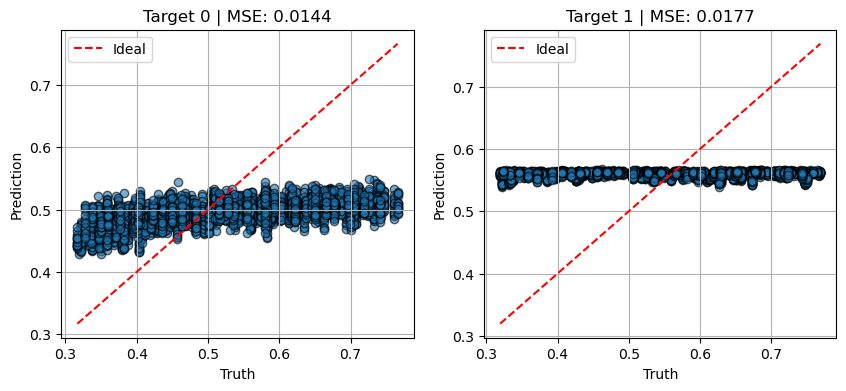

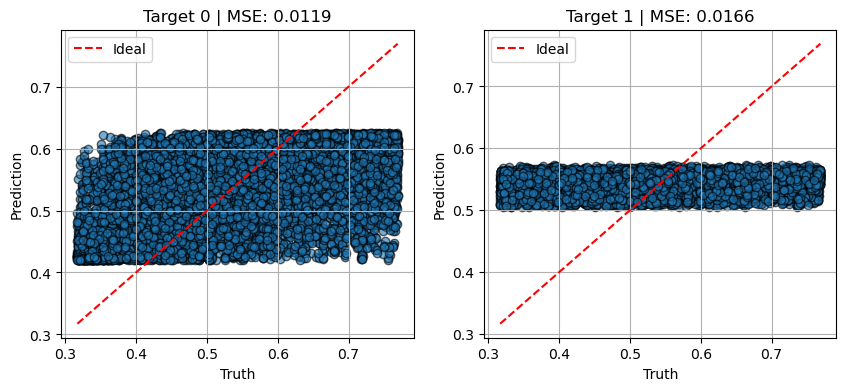

In [38]:
import validator 
importlib.reload(validator)
from validator import *

if False:
    model = CustomCNN(
                input_dim = 256,
                input_channels=1,
                #conv_layers=[(4,3), (8,3), (16, 3), (32, 3)],  # list of (out_channels, kernel_size)
                conv_layers=[(2,3),(4,3), (8,3), (16, 3), (32, 3),(64,3)],  # list of (out_channels, kernel_size)
                hidden_dims=[128, 32],
                output_dim=output_dim,
                output_positive=True,
                activation=nn.LeakyReLU).to(device)
    model.load_state_dict(torch.load("../data/models/SB28_epoch160.pt"))


validate_multi_output_regression(model, val_loader, device=device, max_plots=6)
validate_multi_output_regression(model, train_loader, device=device, max_plots=6)

### Load model and test

Validation MSE (average over 2 targets): 0.003447
Validation MSE (average over 2 targets): 0.000815


(0.0008150689, array([0.00032201, 0.00130813], dtype=float32))

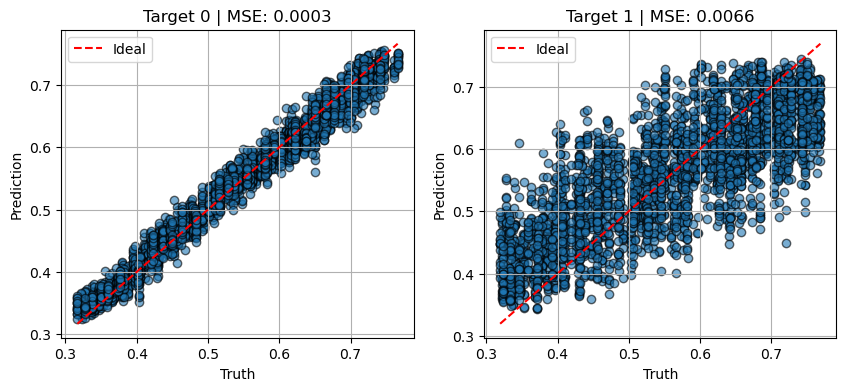

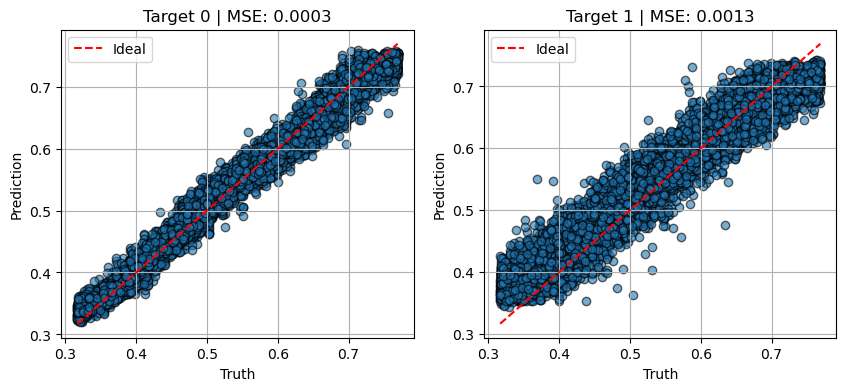

In [8]:
import validator 
importlib.reload(validator)
from validator import *

if True:
    # create CoaT with 1 input channel, 1 output
    model = timm.create_model(
        'coatnet_3_224',
        #'coat_lite_small',      # or any other 'coat_*' variant
        pretrained=False,
        in_chans=1,             # single‐channel input
        #num_classes=2           # single regression output
    )
    out_features = 1000 #model.head.out_features
    # OPTIONAL: wrap the output in a tanh to bound it
    model = nn.Sequential(
        model,
        nn.Linear(out_features, 256),
        nn.LeakyReLU(),
        nn.Dropout(),
        nn.Linear(256, 32),
        nn.LeakyReLU(),
        nn.Dropout(),
        nn.Linear(32, output_dim),
        nn.Sigmoid()
    )
    model = model.to(device)
    model.load_state_dict(torch.load("../data/models/SB28_CoaT_best.pt"))
    model.eval()

if False:
    model = model.to(device)

    model = CustomCNN(
                input_dim = 256,
                input_channels=1,
                #conv_layers=[(4,3), (8,3), (16, 3), (32, 3)],  # list of (out_channels, kernel_size)
                conv_layers=[(2,3),(4,3), (8,3), (16, 3), (32, 3),(64,3)],  # list of (out_channels, kernel_size)
                hidden_dims=[128, 32],
                output_dim=output_dim,
                output_positive=True,
                activation=nn.LeakyReLU).to(device)
    model.load_state_dict(torch.load("../data/models/SB28_epoch160.pt"))


validate_multi_output_regression(model, val_loader, device=device, max_plots=6)
validate_multi_output_regression(model, train_loader, device=device, max_plots=6)

Validation MSE (average over 2 targets): 0.003389
Validation MSE (average over 2 targets): 0.002982


(0.0029817373, array([0.00073751, 0.00522596], dtype=float32))

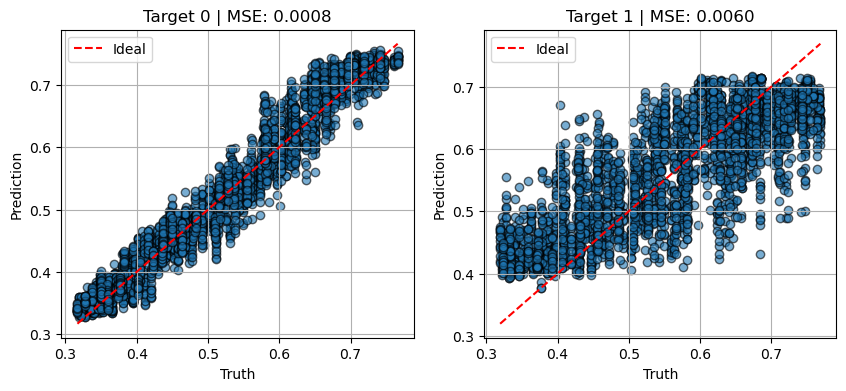

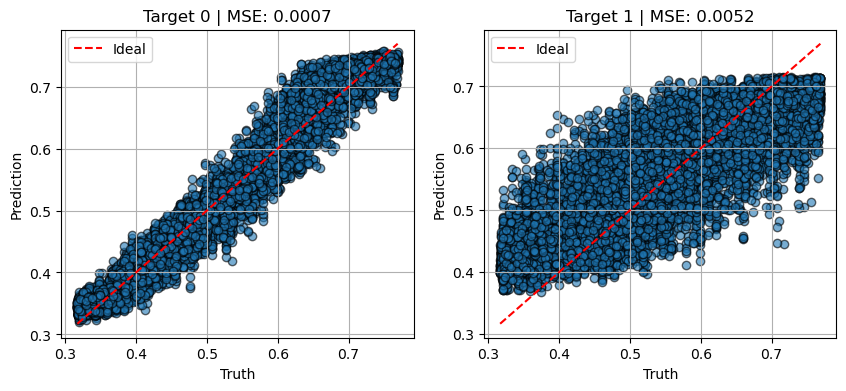

In [9]:
import validator 
importlib.reload(validator)
from validator import *

if True:
    # create CoaT with 1 input channel, 1 output
    model = timm.create_model(
        'coatnet_3_224',
        #'coat_lite_small',      # or any other 'coat_*' variant
        pretrained=False,
        in_chans=1,             # single‐channel input
        #num_classes=2           # single regression output
    )
    out_features = 1000 #model.head.out_features
    # OPTIONAL: wrap the output in a tanh to bound it
    model = nn.Sequential(
        model,
        nn.Linear(out_features, 256),
        nn.LeakyReLU(),
        nn.Dropout(),
        nn.Linear(256, 32),
        nn.LeakyReLU(),
        nn.Dropout(),
        nn.Linear(32, output_dim),
        nn.Sigmoid()
    )
    model = model.to(device)
    model.load_state_dict(torch.load("../data/models/SB28_CoaT_resize_best.pt"))

if False:
    model = model.to(device)

    model = CustomCNN(
                input_dim = 256,
                input_channels=1,
                #conv_layers=[(4,3), (8,3), (16, 3), (32, 3)],  # list of (out_channels, kernel_size)
                conv_layers=[(2,3),(4,3), (8,3), (16, 3), (32, 3),(64,3)],  # list of (out_channels, kernel_size)
                hidden_dims=[128, 32],
                output_dim=output_dim,
                output_positive=True,
                activation=nn.LeakyReLU).to(device)
    model.load_state_dict(torch.load("../data/models/SB28_epoch160.pt"))


validate_multi_output_regression(model, val_loader, device=device, max_plots=6)
validate_multi_output_regression(model, train_loader, device=device, max_plots=6)

##  50 Mpc box SB35

### data load

In [7]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()

3910

In [ ]:
batch_size=64
data, labels = loadCAMELS(field="Mtot",box="SB35")
data = np.log10(data)
data = (data-data.mean())/data.std()
labels = labels[:,:2]
output_dim = labels.shape[1]

In [ ]:
np.isinf(data).any()

False

In [ ]:
data = torch.tensor(data,dtype=dtype)
labels = torch.tensor(labels,dtype=dtype)
train_set, val_set = split_expanded_dataset(data, labels, chunk_size=30, val_ratio=0.2)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

### training

In [ ]:
import structures
importlib.reload(structures)
from structures import *

lr = 1e-3
# Instantiate the model
"""
try: 
    del model
    print("model deleted")
except:
    pass
"""

ds_config = {
    "train_batch_size": batch_size,
    "gradient_accumulation_steps": 1,
    "optimizer": {
        "type": "AdamW",
        "params": {"lr": 1e-3, "betas": [0.9, 0.999], "eps": 1e-8}
    },
    "fp32": {
        "enabled": True  # Enables mixed precision training
    },
    "zero_optimization": {
        "stage": 1  # Enable ZeRO Stage 1 for memory optimization
    }
}

model = CustomCNN(
                input_dim = 512,
                input_channels=1,
                conv_layers=[(4,3), (8,3), (16, 3), (32, 3)],  # list of (out_channels, kernel_size)
                hidden_dims=[128],
                output_dim=output_dim,
                activation=nn.LeakyReLU)

#model = ConventionalCNN(input_shape=(512,512), output_shape=output_dim)

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

model_engine, optimizer, _, _ = deepspeed.initialize(
    model=model,
    model_parameters=model.parameters(),
    config=ds_config
)


for epoch in range(20):
    running_loss = 0.0
    for images, labels in train_loader:
        #print(images,labels)
        images, labels = images.to(device).double(), labels.to(device).double()
        optimizer.zero_grad()
        outputs = model_engine(images)
        loss = criterion(outputs, labels)
        model_engine.backward(loss, retain_graph=True)
        model_engine.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")


[2025-04-14 16:10:48,391] [INFO] [logging.py:128:log_dist] [Rank 0] DeepSpeed info: version=0.16.4, git-hash=unknown, git-branch=unknown
[2025-04-14 16:10:48,392] [INFO] [config.py:734:__init__] Config mesh_device None world_size = 1
[2025-04-14 16:10:48,396] [INFO] [logging.py:128:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
[2025-04-14 16:10:48,397] [INFO] [logging.py:128:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adamw as basic optimizer
[2025-04-14 16:10:48,397] [INFO] [logging.py:128:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2025-04-14 16:10:48,397] [INFO] [logging.py:128:log_dist] [Rank 0] DeepSpeed Basic Optimizer = FusedAdam
[2025-04-14 16:10:48,398] [INFO] [utils.py:59:is_zero_supported_optimizer] Checking ZeRO support for optimizer=FusedAdam type=<class 'deepspeed.ops.adam.fused_adam.FusedAdam'>
[2025-04-14 16:10:48,398] [INFO] [logging.py:128:log_dist] [Rank 0] Creating torch.float32 ZeRO stage 1 optimizer

[2025-04-14 16:10:48,746] [INFO] [utils.py:781:see_memory_usage] After initializing optimizer states
[2025-04-14 16:10:48,748] [INFO] [utils.py:782:see_memory_usage] MA 7.11 GB         Max_MA 7.13 GB         CA 8.5 GB         Max_CA 8 GB 
[2025-04-14 16:10:48,748] [INFO] [utils.py:789:see_memory_usage] CPU Virtual Memory:  used = 211.98 GB, percent = 21.0%
[2025-04-14 16:10:48,749] [INFO] [stage_1_and_2.py:550:__init__] optimizer state initialized
[2025-04-14 16:10:48,886] [INFO] [utils.py:781:see_memory_usage] After initializing ZeRO optimizer
[2025-04-14 16:10:48,887] [INFO] [utils.py:782:see_memory_usage] MA 7.11 GB         Max_MA 7.11 GB         CA 8.5 GB         Max_CA 8 GB 
[2025-04-14 16:10:48,887] [INFO] [utils.py:789:see_memory_usage] CPU Virtual Memory:  used = 212.02 GB, percent = 21.0%
[2025-04-14 16:10:48,902] [INFO] [logging.py:128:log_dist] [Rank 0] DeepSpeed Final Optimizer = DeepSpeedZeroOptimizer
[2025-04-14 16:10:48,902] [INFO] [logging.py:128:log_dist] [Rank 0] Deep

Validation MSE (average over 2 targets): 0.003903


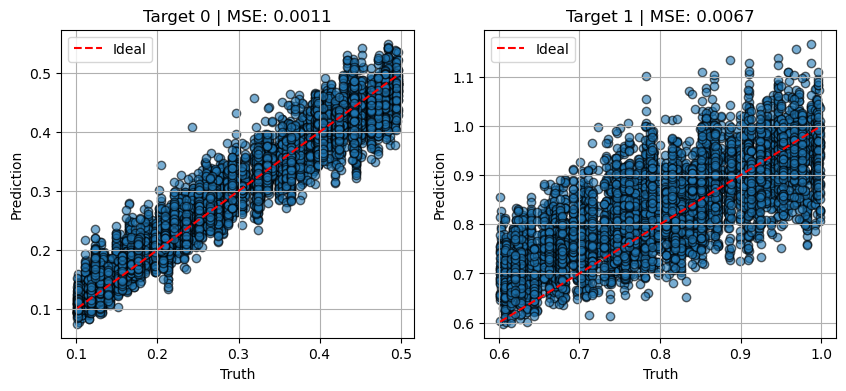

Validation MSE (average over 2 targets): 0.001547


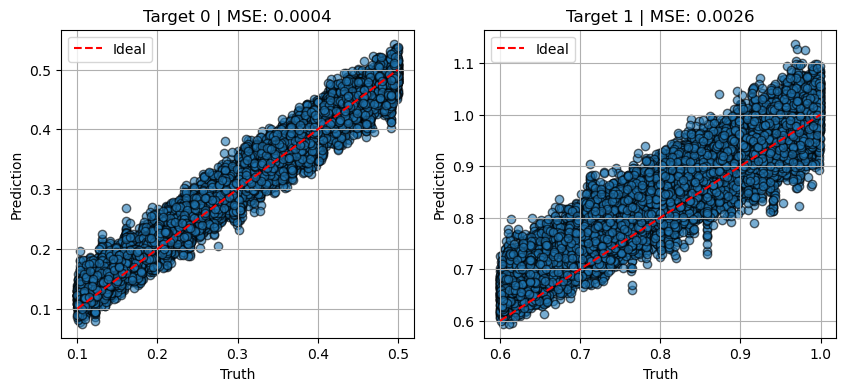

(0.0015468097198318572, array([0.00044484, 0.00264878]))

In [ ]:
import validator 
importlib.reload(validator)
from validator import *

validate_multi_output_regression(model, val_loader, device=device, max_plots=6)
validate_multi_output_regression(model, train_loader, device=device, max_plots=6)

##  25 Mpc cutout box of SB35

### data load

In [29]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()

11986

In [36]:
batch_size=64
_dataSB28, _labelsSB28, _minmaxSB28 = loadCAMELS(field="Mtot",box="SB28", normalization=False)
_dataSB35, _labelsSB35, _minmaxSB35 = loadCAMELS(field="Mtot",box="SB35", normalization=False)

In [37]:
dataSB28_norm = np.log10(_dataSB28)
dataSB28_norm_mean, dataSB28_norm_std = dataSB28_norm.mean(), dataSB28_norm.std()
dataSB28_norm = (dataSB28_norm -  dataSB28_norm_mean)/dataSB28_norm_std

dataSB35_norm = np.log10(_dataSB35[:,:256,:256])
dataSB35_norm = (dataSB35_norm -  dataSB28_norm_mean)/dataSB28_norm_std

labelsSB28 = _labelsSB28[:,:2]
labelsSB35 = _labelsSB35[:,:2]
labelsSB28 = (labelsSB28-minmaxSB28[:2,0])/(minmaxSB28[:2,1]-minmaxSB28[:2,0])
labelsSB35 = (labelsSB35-minmaxSB28[:2,0])/(minmaxSB28[:2,1]-minmaxSB28[:2,0])

In [38]:
dataSB28 = torch.tensor(dataSB28_norm,dtype=dtype)
labelsSB28 = torch.tensor(labelsSB28,dtype=dtype)
train_setSB28, val_setSB28 = split_expanded_dataset(dataSB28, labelsSB28, chunk_size=15, val_ratio=0.2)
val_loaderSB28 = DataLoader(val_setSB28, batch_size=batch_size, shuffle=False)

dataSB35 = torch.tensor(dataSB35_norm,dtype=dtype)
labelsSB35 = torch.tensor(labelsSB35,dtype=dtype)
train_setSB35, val_setSB35 = split_expanded_dataset(dataSB35, labelsSB35, chunk_size=30, val_ratio=0.2)
val_loaderSB35 = DataLoader(val_setSB35, batch_size=batch_size, shuffle=False)

Validation MSE (average over 2 targets): 0.003139
Validation MSE (average over 2 targets): 0.003510


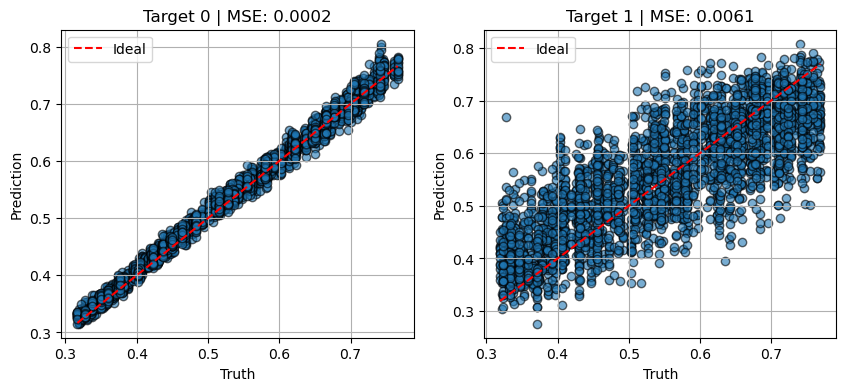

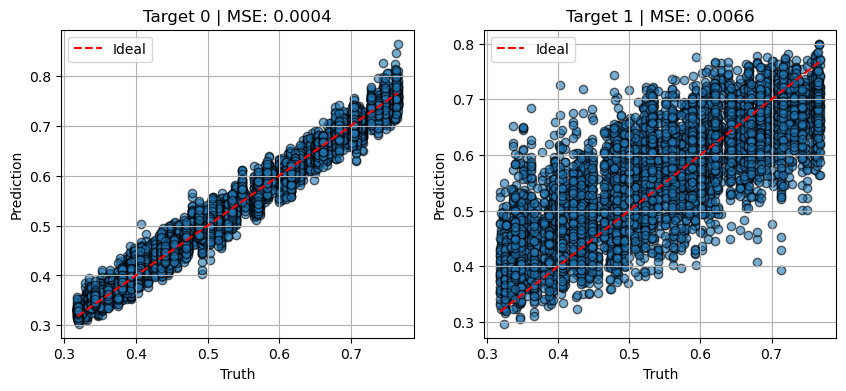

In [40]:
import validator 
importlib.reload(validator)
from validator import *
output_dim = labelsSB28.shape[1]

model = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model.to(device)
model.load_state_dict(torch.load("../data/models/SB28_conv_epoch100.pt"))

validate_multi_output_regression(model, val_loaderSB28, device=device, max_plots=6)
validate_multi_output_regression(model, val_loaderSB35, device=device, max_plots=6)
plt.savefig("train_on_SB28_test_on_both.png")